# Summary 

This notebook contains the analysis on voltage change detection at different pointwidth.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import btrdb

from datetime import datetime, timedelta
from btrdb.utils.timez import ns_delta, ns_to_datetime, to_nanoseconds
from library.utils import streams_to_df

plt.style.use('fivethirtyeight')
%load_ext autoreload
%autoreload 2

In [2]:
#Establishing the connecting to the server
db = btrdb.connect(profile='ni4ai')

In [3]:
#Choosing streams; we are choosing PMU3 here.
streams = db.streams_in_collection('sunshine/PMU3', tags={'unit': 'volts'})
base = 7.2e3

In [4]:
stream = streams[0]
start, _ = stream.earliest()
end, _ = stream.latest()

## pw=44

In [86]:
pw = 44 # or 2^44 nanoseconds
df = streams_to_df(streams[0], start.time, end.time, pw=pw, 
                  agg= ['min','mean','max','stddev'], to_datetime=True)
df = df/base
dt = to_nanoseconds(df.index[1]) - to_nanoseconds(df.index[0])

print(f'pointwidth : {dt/1e9/60} minutes')
print(f'statpoints: {df.shape[0]} points')
df.head()

Getting streams:   0%|          | 0/1 [00:00<?, ?it/s]

pointwidth : 293.20310073173334 minutes
statpoints: 2892 points


collection                    sunshine/PMU3                              
unit                                  volts                              
name                                  L1MAG                              
agg                                  stddev      mean       max       min
time                                                                     
2015-07-27 23:01:03.828697088      0.005368  1.005435  1.014460  0.993667
2015-07-28 03:54:16.014741504      0.003903  1.001537  1.009557  0.986486
2015-07-28 08:47:28.200785920      0.004753  0.994815  1.006381  0.971215
2015-07-28 13:40:40.386830336      0.002674  0.990515  0.997378  0.981020
2015-07-28 18:33:52.572874752      0.005445  0.997871  1.019361  0.985100

In [87]:
def plot_ts(df, ax, stddev_thres=3, xlim=None, ylim=None, xlabel='', ylabel='', title=''):
    ax.fill_between(df.index, 
                   (df.xs('mean', level='agg', axis=1)-stddev_thres*df.xs('stddev', level='agg', axis=1)).iloc[:,0], 
                   (df.xs('mean', level='agg', axis=1)+stddev_thres*df.xs('stddev', level='agg', axis=1)).iloc[:,0],
                   alpha=0.3, color='tan')
    
    ax.plot(df.xs('mean', level='agg', axis=1), label='interval mean', ls=' ', 
            marker='.', color='k', ms=1)
    ax.plot(df.xs('min', level='agg', axis=1), label='interval min', ls=' ', 
            marker='_', ms=2, alpha=0.5)
    ax.plot(df.xs('max', level='agg', axis=1), label='interval max', ls=' ', 
            marker='_', ms=2, alpha=0.5)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
    ax.set_ylabel(xlabel)
    
    start_dt = df.index[0]
    end_dt = df.index[-1]
    ticks = pd.date_range(start=datetime(start_dt.year,start_dt.month,1), 
                          end=datetime(end_dt.year,end_dt.month,1), 
                          freq='m')
    ax.set_xticks(ticks)
    ax.set_xticklabels([t.strftime('%Y-%m-%d') for t in ticks], rotation=45, ha='right')
    ax.legend(loc='upper right', fontsize=10, bbox_to_anchor=(1, 1.1))
    ax.set_title(title)

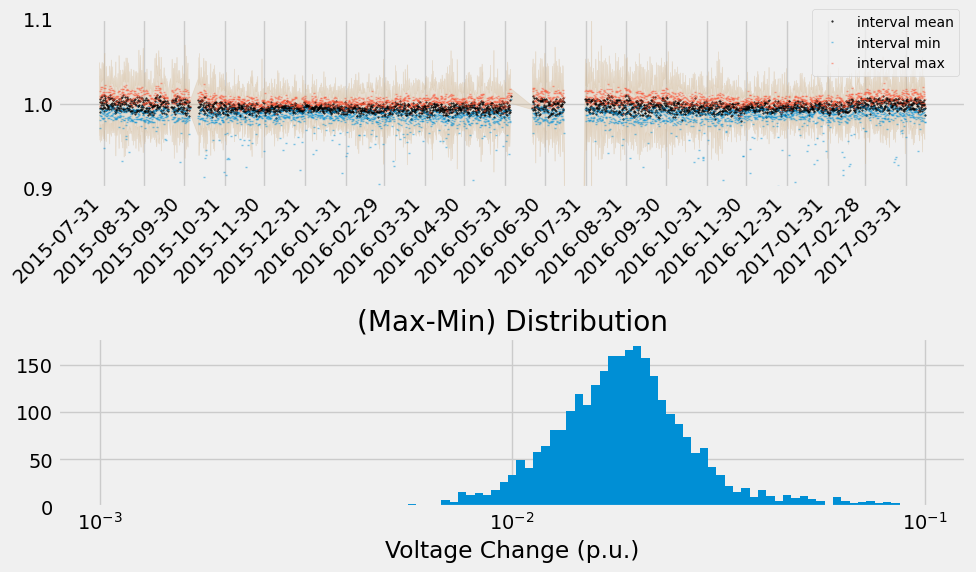

In [88]:
fig, ax = plt.subplots(figsize=(10,6), nrows=2)
plot_ts(df, ax[0], stddev_thres=8, ylim=(0.9,1.1), ylabel='Voltage (p.u.)')

ax[1].hist(df.xs('max', level='agg', axis=1)-df.xs('min', level='agg', axis=1), 
           bins=np.logspace(-3,-1, 100))
ax[1].set_xlabel('Voltage Change (p.u.)')
ax[1].set_xscale('log')
ax[1].set_title('(Max-Min) Distribution')
plt.tight_layout()
plt.show()

## pw=38

In [89]:
pw = 38 # or 2^38 nanoseconds
df = streams_to_df(streams[0], start.time, end.time, pw=pw, 
                  agg= ['min','mean','max','stddev'], to_datetime=True)
df = df/base
dt = to_nanoseconds(df.index[1]) - to_nanoseconds(df.index[0])

print(f'pointwidth : {dt/1e9/60} minutes')
print(f'statpoints: {df.shape[0]} points')
df.head()

Getting streams:   0%|          | 0/1 [00:00<?, ?it/s]

pointwidth : 4.581298453333333 minutes
statpoints: 184549 points


collection                    sunshine/PMU3                              
unit                                  volts                              
name                                  L1MAG                              
agg                                  stddev      mean       max       min
time                                                                     
2015-07-27 23:56:02.363580416      0.000464  1.005208  1.006479  1.003660
2015-07-28 00:00:37.241487360      0.000506  1.005566  1.007180  1.003439
2015-07-28 00:05:12.119394304      0.000839  1.007294  1.009009  1.003875
2015-07-28 00:09:46.997301248      0.000598  1.008276  1.009292  1.006113
2015-07-28 00:14:21.875208192      0.000926  1.010129  1.012520  1.006857

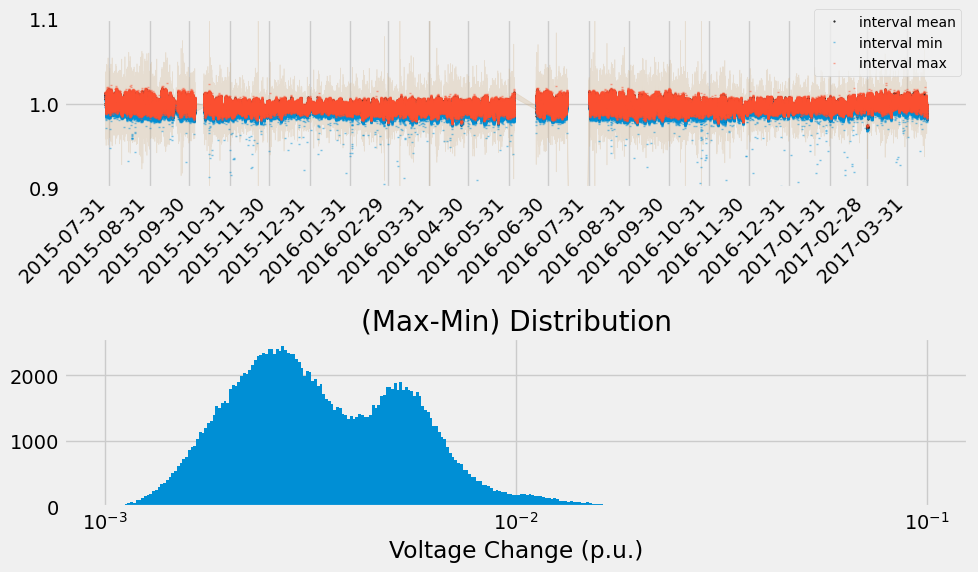

In [90]:
fig, ax = plt.subplots(figsize=(10,6), nrows=2)
plot_ts(df, ax[0], stddev_thres=8, ylim=(0.9,1.1), ylabel='Voltage (p.u.)')
ax[1].hist(df.xs('max', level='agg', axis=1)-df.xs('min', level='agg', axis=1), 
           bins=np.logspace(-3,-1, 300))
ax[1].set_xlabel('Voltage Change (p.u.)')
ax[1].set_xscale('log')
ax[1].set_title('(Max-Min) Distribution')
plt.tight_layout()
plt.show()

## Gaussian Mixture Model

In [91]:
from sklearn.mixture import GaussianMixture

In [92]:
n = 4
diff = (df.xs('max', level='agg', axis=1) - df.xs('min', level='agg', axis=1)).astype(float).to_numpy()

X = np.log(diff).reshape((len(df),1))
gm = GaussianMixture(n_components=n, random_state=0, verbose=3).fit(X)

Initialization 0
  Iteration 10	 time lapse 0.61941s	 ll change 0.00146
Initialization converged: True	 time lapse 0.73169s	 ll -0.74295


In [93]:
np.vstack([gm.means_[:,0], gm.covariances_[:,0,0]])

array([[-6.13003823, -5.66031778, -9.64016468, -5.29031124],
       [ 0.05873615,  0.11345675,  0.2453139 ,  0.21151314]])

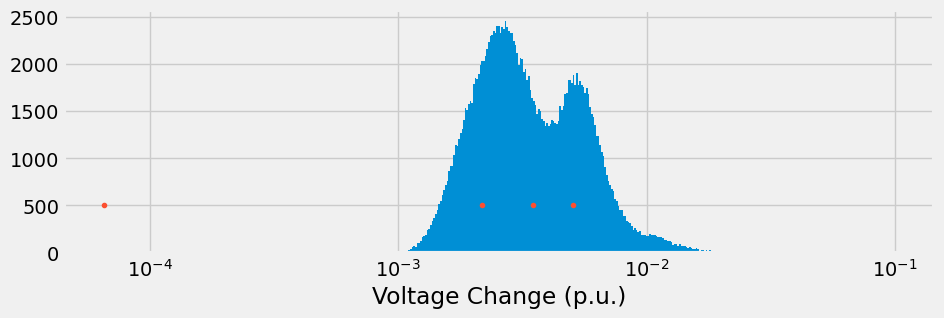

In [94]:
fig, ax = plt.subplots(figsize=(10,3))
ax.hist(diff, bins=np.logspace(-3,-1, 300))
ax.plot(np.exp(gm.means_[:,0]), [500 for ix in range(n)], ls=' ', marker='.')
ax.set_xlabel('Voltage Change (p.u.)')
ax.set_xscale('log')
plt.show()

In [96]:
clusters = []
for i in range(n):
    clusters.append(np.exp(np.random.normal(gm.means_[i,0], gm.covariances_[i,0,0], int(1e8*gm.weights_[i,]))))
    print(i, len(clusters[-1]))

0 34256628
1 27973764
2 493196
3 37276410


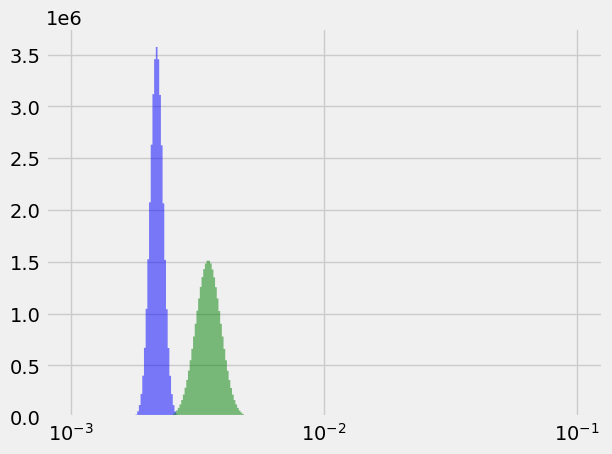

In [98]:
fig, ax = plt.subplots()
bins = np.logspace(-3,-1, 300)
ax.set_xscale('log')
ax.hist(clusters[0], color='b', alpha=0.5, histtype='stepfilled', bins=bins)
ax.hist(clusters[1], color='g', alpha=0.5, histtype='stepfilled', bins=bins)
ax.hist(clusters[2], color='r', alpha=0.5, histtype='stepfilled', bins=bins)
plt.show()